<a href="https://colab.research.google.com/github/eportah/Bird-of-Prey-Identifier/blob/main/buildModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup dataset

#mount the drive to retrieve dataset
from google.colab import drive
drive.mount('/content/drive')

#import ZipFile to read dataset
from zipfile import ZipFile

#establish paths
zipPath = "/content/drive/MyDrive/MachineLearning/Datasets/birdsDatasets.zip"
extractPath = "/content/extractPath"

#extract and open dataset in read mode using ZipFile
with ZipFile(zipPath, 'r') as zipObj:
   zipObj.extractall(extractPath)

Mounted at /content/drive


In [2]:
#load dataset

#cell output rundown
"""
- Dataset has 300 files (images) split into 2 classes.
- Class names are 'birdsOfPrey' and 'notBirdsOfPrey'.
- Images are batched into groups of 32, resized to 224x224 pixels, with 3 color channels RGB.
- Labels are stored in 1-D array of length 32, one label per image in the batch.
"""

#store dataset path into variable and import tensorflow to load images from directory
datasetDirectory = "/content/extractPath/birdsDataset"
import tensorflow as tf

#load dataset with function image_dataset_from_directory and establish both image size and batch size
trainDataset = tf.keras.utils.image_dataset_from_directory(datasetDirectory, image_size=(224,224), batch_size=32)

#preview what got loaded and what dataset looks like
class_names = trainDataset.class_names
print("Class names:", class_names)
for images, labels in trainDataset.take(1):
  print("Image batch shape:", images.shape)
  print("Label batch shape:", labels.shape)

Found 300 files belonging to 2 classes.
Class names: ['birdsOfPrey', 'notBirdsOfPrey']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [3]:
#split dataset

#cell output rundown
"""
- 210, 70% for training
- 90, 30% for validation
- Batch sizes are the same for both training and validation
"""

#load training dataset, 70% of data
trainingDataset = tf.keras.utils.image_dataset_from_directory(
   datasetDirectory,
   validation_split=0.3,
   subset="training",
   seed=123,
   image_size=(224,224),
   batch_size=32
)

#load validation dataset, 30% of data
validationDataset = tf.keras.utils.image_dataset_from_directory(
   datasetDirectory,
   validation_split=0.3,
   subset="validation",
   seed=123,
   image_size=(224,224),
   batch_size=32
)

#preview one batch from training dataset
print("Training batch shapes:")
for imagesTrain, labelsTrain in trainingDataset.take(1):
  print("Images:", imagesTrain.shape)
  print("Labels:", labelsTrain.shape)

#preview one batch from validation dataset
print("Validation batch shapes:")
for imagesVal, labelsVal in validationDataset.take(1):
 print("Images:", imagesVal.shape)
 print("Labels:", labelsVal.shape)

Found 300 files belonging to 2 classes.
Using 210 files for training.
Found 300 files belonging to 2 classes.
Using 90 files for validation.
Training batch shapes:
Images: (32, 224, 224, 3)
Labels: (32,)
Validation batch shapes:
Images: (32, 224, 224, 3)
Labels: (32,)


In [4]:
#preprocess dataset

#import MobileNetV2 preprocessing
from keras.applications.mobilenet_v2 import preprocess_input

#define dataAugmentation
dataAugmentation = tf.keras.Sequential([
   tf.keras.layers.RandomFlip("horizontal"),
   tf.keras.layers.RandomRotation(0.1),
   tf.keras.layers.RandomZoom(0.1)
])

#apply augmentation and MobileNetV2 preprocessing to training set using map to transform batches of images
trainSet = trainingDataset.map(lambda x, y: (preprocess_input(dataAugmentation(x)),y))

#apply MobileNetV2 preprocessing to validation set still using map to transform batches of images
validSet = validationDataset.map(lambda x, y: (preprocess_input(x),y))

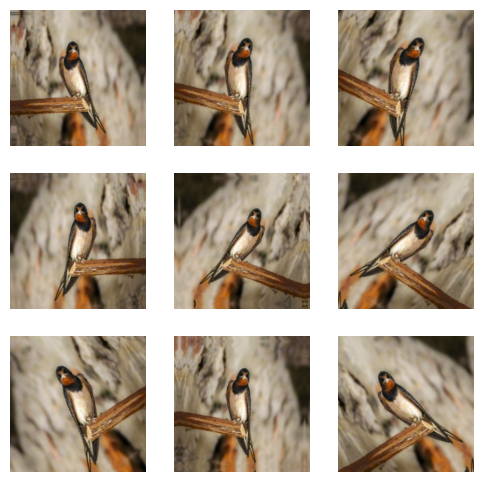

In [5]:
#preview augmentation

#import pyplot to visualize tensors as images and numpy for numpy indexing
import matplotlib.pyplot as plt
import numpy as np

#take one raw image from unmapped training dataset and select first image and its label, shape (224, 224, 3)
for imgs, labs in trainingDataset.take(1):
  batchImages = imgs.numpy()
  batchLabels = labs.numpy()
sampleImage = batchImages[0]
sampleLabel = batchLabels[0]

#establish grid and create a figure for plotting
augmentedNum = 9
plt.figure(figsize = (6,6))

#add batch dimension and apply augmentation
for i in range(augmentedNum):
  imgBatch = np.expand_dims(sampleImage, axis = 0)
  imgAugmented = dataAugmentation(imgBatch)[0].numpy()

  #clip to ensure values are within range and cast to convert the aray from floats to 8-bit unsigned integers
  imgAugmented = np.clip(imgAugmented, 0, 255).astype("uint8")

  #finish off by plotting each augmented image in a 3x3 grid
  axes = plt.subplot(3,3, i+1)
  axes.imshow(imgAugmented)
  axes.axis('off')

In [6]:
#build model

#import MobileNetV2 to use as base
from keras.applications import MobileNetV2
from keras import layers, models

#load base MobiletNetV2 and drop original classifier
baseModel = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

#freeze base so pretrained weights are not trained right away
baseModel.trainable = False

#add custom classifier head by using layers
"""
Rectified linear unit relu to prevent exploding values
Softmax to turn output into probabilites that add up to 1, each value shows chances an image could belong to a class
Dense layer to learn how much each feature matters for classying a species with another
GAP2D to squeeze feature maps into single vector per channel instead of flattening huge tensors
Dropout to randomly turn off 30% neurons during training to prevent overfitting
"""
model = models.Sequential([
    baseModel,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation = 'softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
